In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from scipy import special
import math
import yaml
from copy import deepcopy
from numba import jit, njit
rng = np.random.default_rng() # initialize generator instance
from mpl_toolkits import mplot3d # for vizualization
%matplotlib notebook
from time import time
from pathlib import Path

In [3]:
imageParams = { #'sigmaxy'    : np.float_(33.25),
                #'sigmaxy'    : np.float_(.007),
                'sigmaxy'    : np.float_(.01),
                'sigmaz'     : np.float_(4.0),
                'A'          : np.float_(10.0),
                'bkglevel'   : np.float_(0.0),
                'noisestd'   : np.float_(0.0),
                #'pixelsize'  : np.float_(.1067),
                'pixelsize'  : np.float_(.01067),
                'modeloffset': np.float_(90.0)}

In [4]:
class filament():
    def __init__(self, line):
        data = line.split()
        self.gid = data[1]
        dat = np.asarray(data[2:], dtype=np.double)
        self.radius = dat[0]
        self.minus_end = dat[1:4]
        self.plus_end = dat[4:]
        
        self.vec = self.plus_end - self.minus_end
        self.lengthxy = np.linalg.norm(self.vec[:-1])
        self.length = np.linalg.norm(self.vec)
        self.orientation = self.vec/self.length
        
        self.theta = -np.arctan2(self.orientation[1], self.orientation[0])
        

In [5]:
def read_dat_sylinder(fpath):
    # Read a SylinderAscii_X.dat file

    # open the file and read the lines
    with fpath.open('r') as file1:
        filecontent = file1.readlines()

        # Delete the first two lines because they dont have any data
        filecontent[0:2] = []  
        
        # Create list of filaments
        filaments = sorted([filament(line) for line in filecontent], key=lambda x: x.gid)    
    return filaments



In [6]:
@jit
def GaussianLine2D(x, y, A, sigma, x0, y0, L, theta):
    term0 = (y-y0)*np.cos(theta)+(x0-x)*np.sin(-theta)
    expterm = A*np.exp(-term0*term0/(2*sigma*sigma))
    erfterm = (special.erf((L+(x0-x)*np.cos(theta)+(y0-y)*np.sin(-theta))/(np.sqrt(2)*sigma)) \
             - special.erf(((x0-x)*np.cos(theta)+(y0-y)*np.sin(-theta))/(np.sqrt(2)*sigma)))

    z = expterm*erfterm
    return z

In [7]:
def make_image_bkg(box_dim, image_params):
    pixelSize = image_params['pixelsize']
    noiseStd = image_params['noisestd']
    bkglevel = image_params['bkglevel']

    numPixelsX = np.int_(np.ceil((box_dim[0])/pixelSize))
    numPixelsY = np.int_(np.ceil((box_dim[1])/pixelSize))

    xpixels = np.arange(0,numPixelsX)
    ypixels = np.arange(0,numPixelsY)
    [X,Y] = np.meshgrid(xpixels, ypixels)
    #print(bkglevel)

    imagedata = bkglevel * np.ones((numPixelsX, numPixelsY)) + np.random.standard_normal((numPixelsX, numPixelsY))*noiseStd
    #print(imagedata)
    return X*pixelSize, Y*pixelSize, imagedata
    

In [8]:
def draw_2d_gauss_filament(X, Y, image_params, fil):
    A = image_params['A']
    sigma = image_params['sigmaxy']
    
    imagedata = GaussianLine2D(X,Y, A, sigma, fil.minus_end[0], fil.minus_end[1], fil.lengthxy, fil.theta)
    return imagedata
    

In [9]:
def draw_2d_gauss_cap(X, Y, image_params, fil):
    A = image_params['A']
    sigma = image_params['sigmaxy']
    
    imagedata = GaussianLine2D(X,Y, A, sigma, fil.plus_end[0], fil.plus_end[1], 8.*fil.radius, fil.theta + np.pi)
    return imagedata
    

In [11]:
# Try to read data from file
rng = np.random.default_rng()
imageParams = {
                'sigmaxy'    : np.float_(.007),
                'A'          : np.float_(10.0),
                'bkglevel'   : np.float_(0.0),
                'noisestd'   : np.float_(0.0),
                'pixelsize'  : np.float_(.01067),
              }
file_path = Path("./test_results/SylinderAscii_0.dat")
filaments = read_dat_sylinder(file_path)

with open('TestConfig.yaml', 'r') as yf:
    run_params = yaml.safe_load(yf)
    
sim_box = np.asarray(run_params['simBoxHigh'])
print(sim_box)
X, Y, imagedata_highres = make_image_bkg(sim_box, imageParams)
t0 = time()
for fil in rng.choice(filaments, 5000, replace=False):
    imagedata_highres += draw_2d_gauss_filament(X, Y, imageParams, fil)
print("Time to graph: {:.3g} sec".format(time()-t0))

[5.03 5.03 5.03]
Time to graph: 46.7 sec


<IPython.core.display.Javascript object>


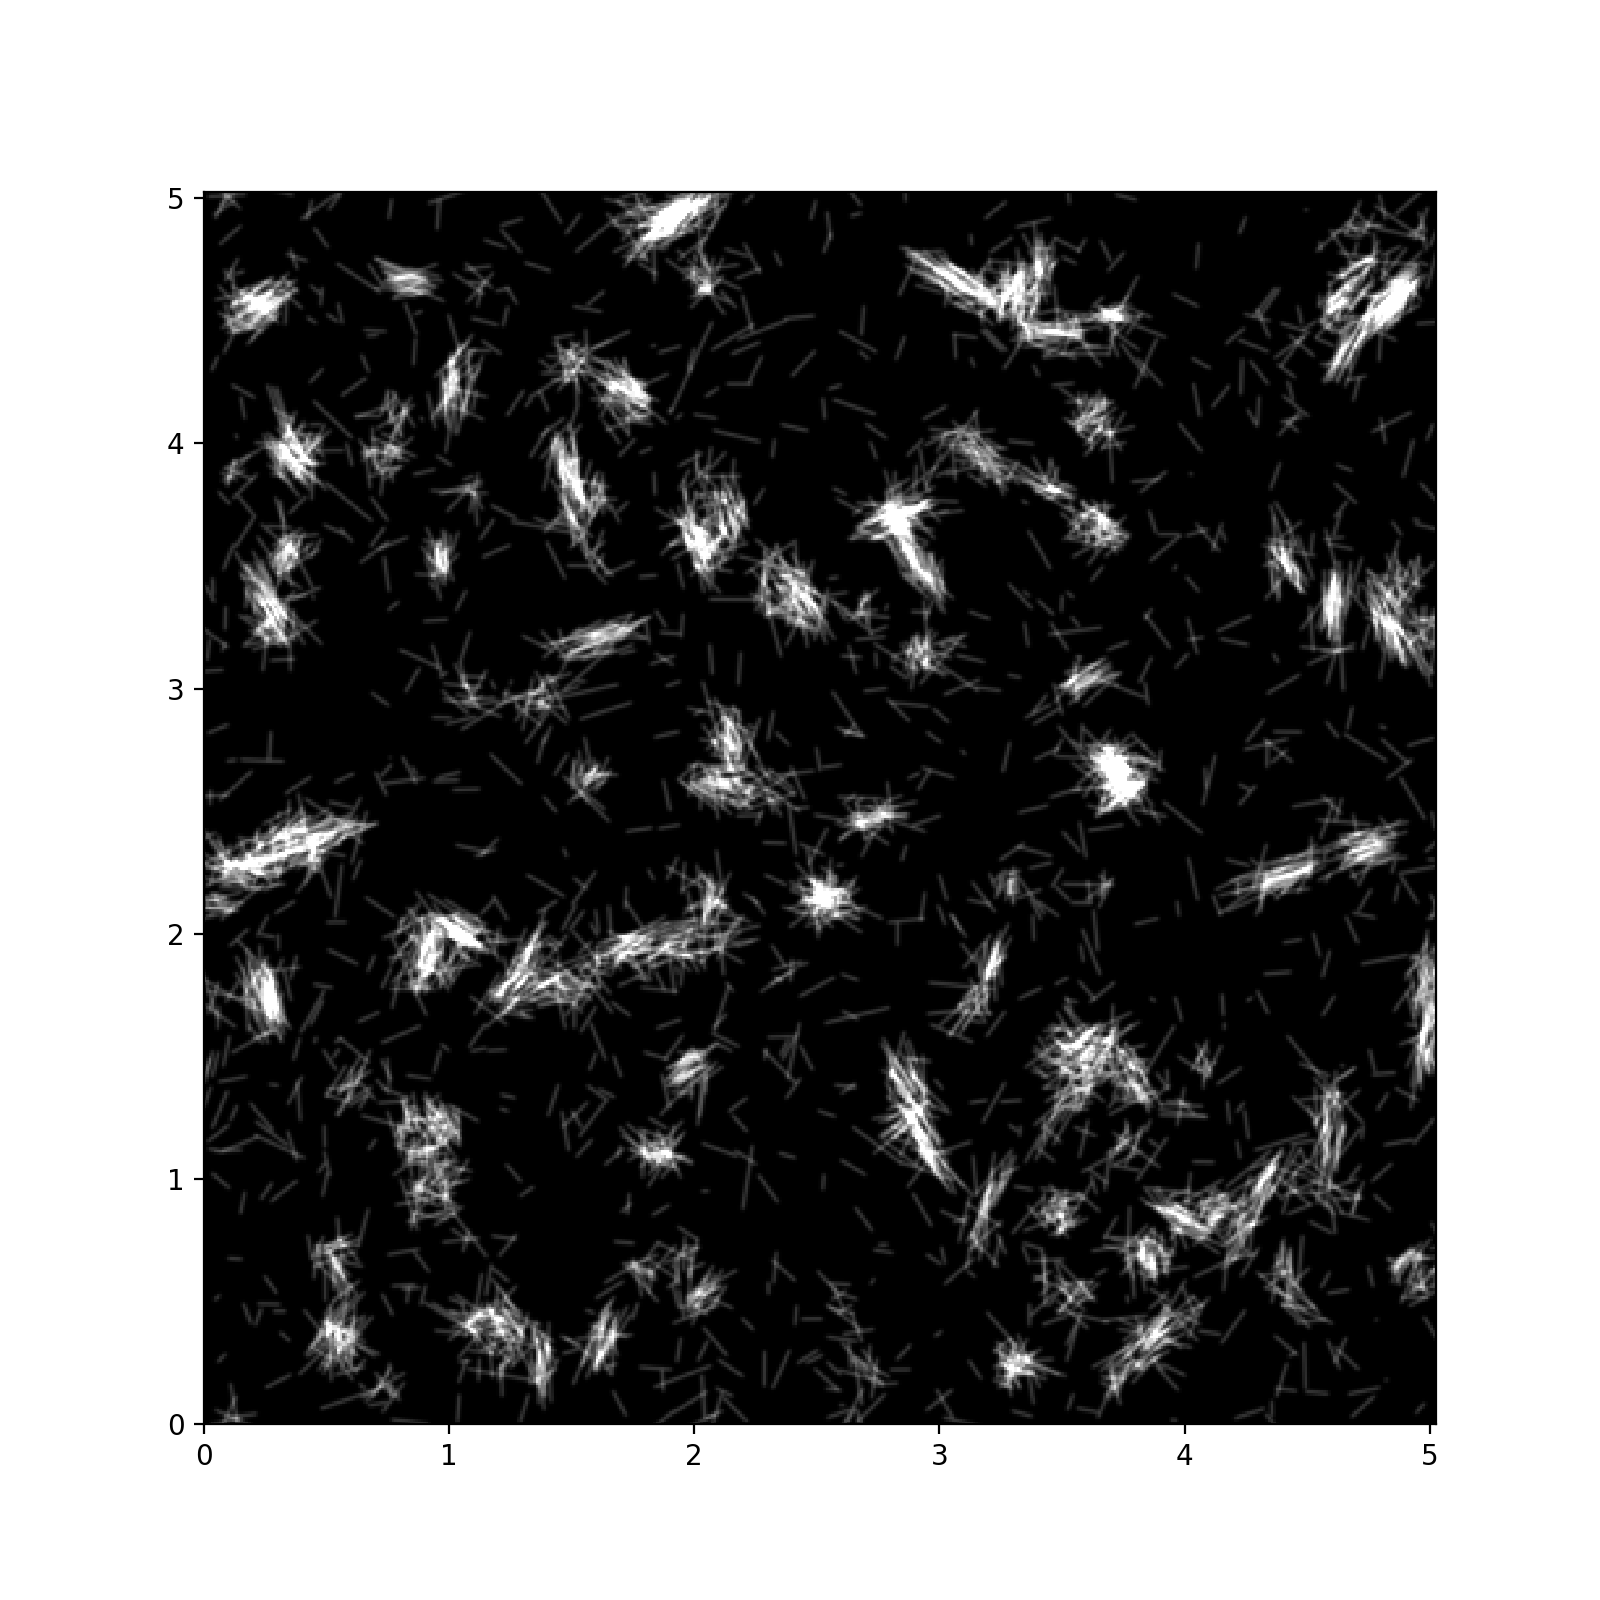

In [11]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
ax.pcolormesh(X, Y, imagedata_highres, cmap='gray', vmax=10.*imageParams["A"])

In [14]:
rng = np.random.default_rng()
graph_frac = .2
imageParams = { #'sigmaxy'    : np.float_(33.25),
                'sigmaxy'    : np.float_(.015),
                'A'          : np.float_(10.0),
                'bkglevel'   : np.float_(0.0),
                'noisestd'   : np.float_(0.0),
                #'pixelsize'  : np.float_(.1067),
                'pixelsize'  : np.float_(.01067),
                'graph_frac' : .2}
file_name = Path("./TubuleTest.dat")
filaments = read_dat_sylinder(file_name)
nfils = len(filaments)
print("Total filaments: {}, filaments graphed: {} ({}\%)".format(nfils, int(nfils*graph_frac), graph_frac*100))

with open('TestConfig.yaml', 'r') as yf:
    run_params = yaml.safe_load(yf)
    
sim_box = np.asarray(run_params['simBoxHigh'])
print(sim_box)
X, Y, imagedata_cap = make_image_bkg(sim_box, imageParams)
t0 = time()
for fil in rng.choice(filaments, int(nfils*graph_frac)):
    imagedata_cap += draw_2d_gauss_cap(X, Y, imageParams, fil)
print("Time to graph: {}".format(time()-t0))

Total filaments: 25600, filaments graphed: 5120 (20.0\%)
[5.03 5.03 5.03]
Time to graph: 36.518107891082764


<IPython.core.display.Javascript object>


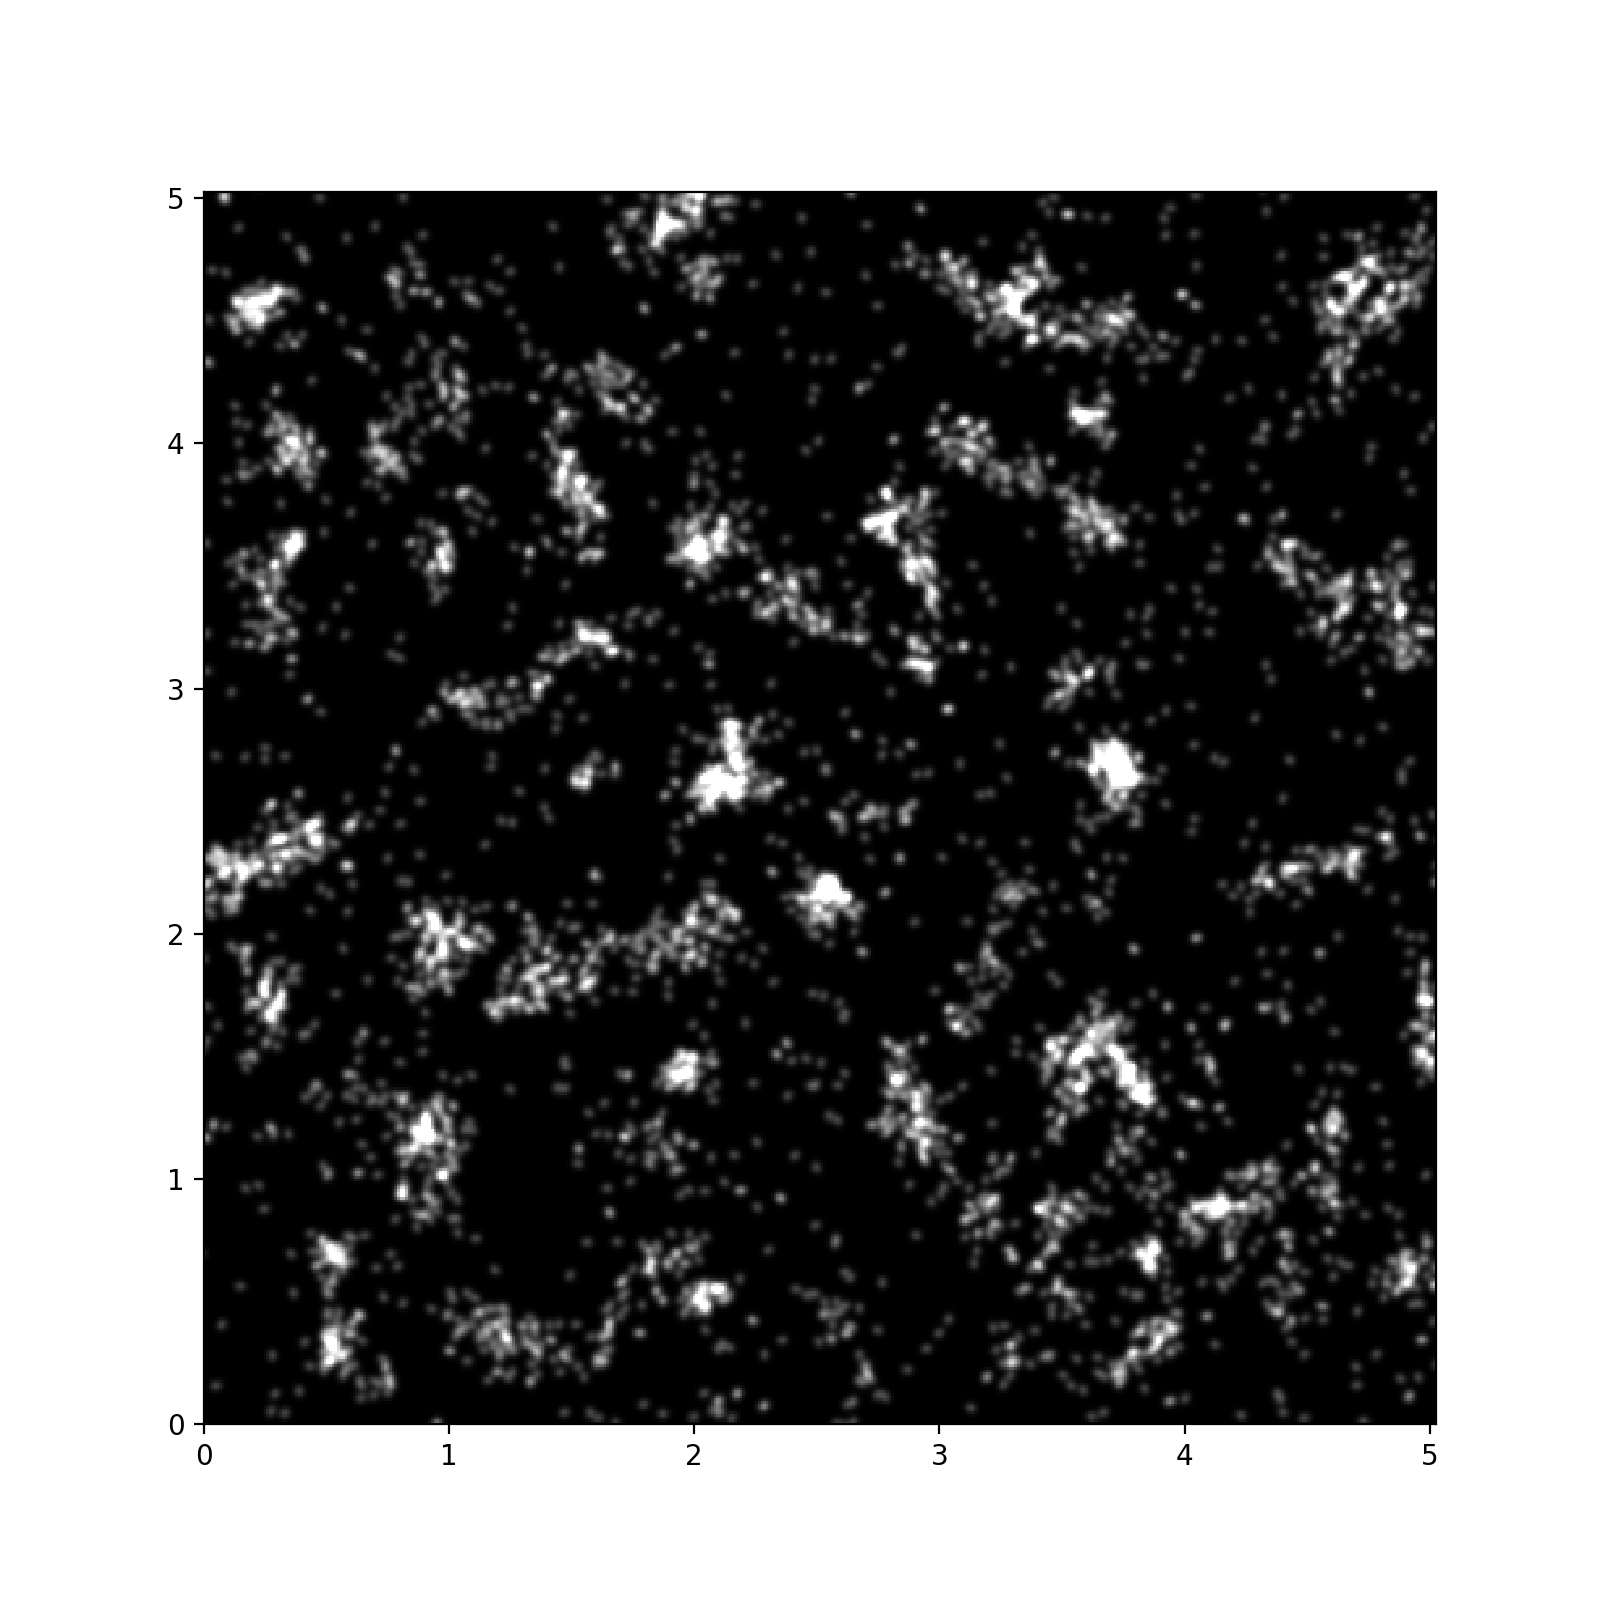

In [30]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
ax.pcolormesh(X, Y, imagedata_cap, cmap='gray', vmax=5.*imageParams["A"])

In [12]:
def get_file_number(path):
    name = path.stem
    num = name.split("_")[-1]
    return int(num)

# Testing
expect_num = 42
test_path = Path("./SylinderAscii_{}.dat".format(expect_num))
num = get_file_number(test_path)
print("Numbers should be the same: {} == {}".format(expect_num, num))
if expect_num == num:
    print("Pass")
else:
    print("Fail")

def count_fils(path):
    with path.open('r') as pf:
        for i, l in enumerate(pf,-1): # Don't count first two lines
            pass
    return i

Numbers should be the same: 42 == 42
Pass


In [13]:
def create_fluor_frame(fil_dat_path, fil_idx_arr, run_params, image_params, draw_func = draw_2d_gauss_filament):
    # Get filament data
    filaments = read_dat_sylinder(fil_dat_path)
    # Get dimensions of simulation
    sim_box = np.asarray(run_params['simBoxHigh'])
    # Create background to draw filaments
    X, Y, image_data = make_image_bkg(sim_box, image_params)
    
    #t0 = time()
    for i in fil_idx_arr:
        image_data += draw_func(X, Y, image_params, filaments[i])
        
    return image_data     
    #print("Time to graph: {}".format(time()-t0))

In [17]:
def animate(i, ax, X, Y, frames, vmax):   
    ax.clear()
    pcm = ax.pcolormesh(X, Y, frames[i], cmap='gray', vmax=vmax)
    ax.set_title("Frame {}".format(i))
    return pcm

In [ ]:
image_params = { 
                'sigmaxy'    : np.float_(.007),
                'A'          : np.float_(10.0),
                'bkglevel'   : np.float_(0.0),
                'noisestd'   : np.float_(0.0),
                'pixelsize'  : np.float_(.01067),
                'graph_frac' : np.float_(.1),
              }

with open('TestConfig.yaml', 'r') as yf:
    run_params = yaml.safe_load(yf)

result_dir = Path("./test_results/")
fil_dat_paths = sorted([tp for tp in result_dir.glob("SylinderAscii*.dat")], key=get_file_number)

rng = np.random.default_rng()
nfils = count_fils(fil_dat_paths[0])

fil_idx_arr = rng.choice(nfils, int(nfils*image_params['graph_frac']))
print("Total filaments: {}, filaments graphed: {} ({}%)".format(nfils, int(nfils*image_params['graph_frac']), image_params['graph_frac']*100))

X, Y, _ = make_image_bkg(sim_box, image_params)
print(len(fil_idx_arr))

frames = []
for i, fdp in enumerate(fil_dat_paths):
    t0 = time()
    frames += [create_fluor_frame(fdp, fil_idx_arr, run_params, image_params)]
    print("Frame {} created in: {:.2g} sec".format(i, time()-t0))
#print("Time to graph: {}".format(time()-t0))

Total filaments: 25600, filaments graphed: 2560 (10.0%)
2560
Frame 0 created in: 26 sec
Frame 1 created in: 25 sec
Frame 2 created in: 39 sec
Frame 3 created in: 37 sec
Frame 4 created in: 33 sec
Frame 5 created in: 30 sec
Frame 6 created in: 28 sec
Frame 7 created in: 28 sec
Frame 8 created in: 28 sec
Frame 9 created in: 27 sec
Frame 10 created in: 28 sec
Frame 11 created in: 28 sec
Frame 12 created in: 28 sec
Frame 13 created in: 31 sec
Frame 14 created in: 30 sec
Frame 15 created in: 29 sec
Frame 16 created in: 28 sec
Frame 17 created in: 28 sec
Frame 18 created in: 29 sec
Frame 19 created in: 28 sec
Frame 20 created in: 27 sec
Frame 21 created in: 29 sec


<IPython.core.display.Javascript object>


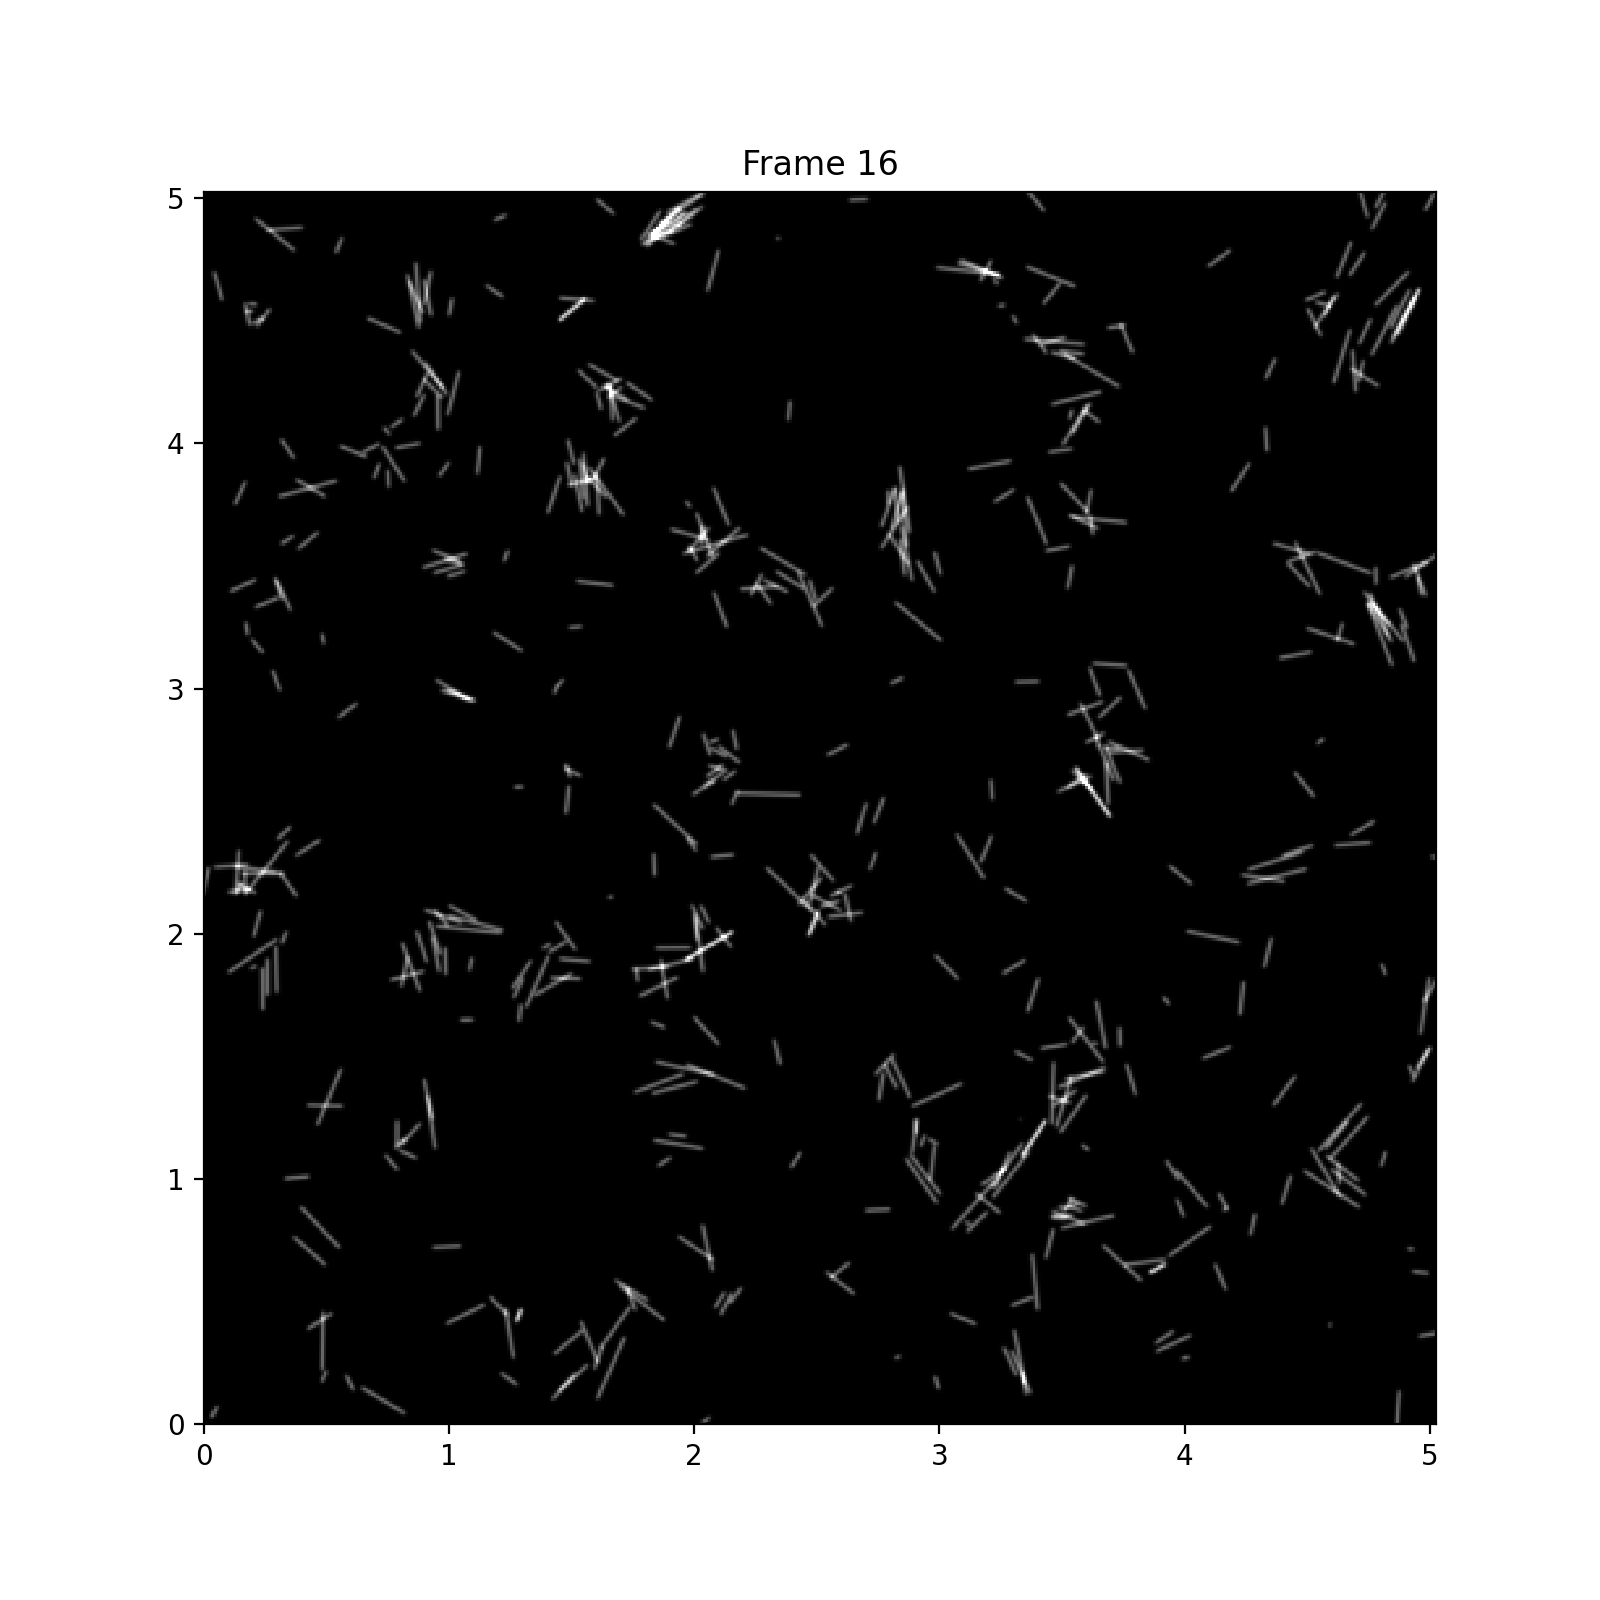

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
ani = FuncAnimation(fig, animate, len(frames), fargs=(ax, X, Y, frames, 5.*image_params['A']), blit=True)

In [27]:
image_params = { 
                'sigmaxy'    : np.float_(.015),
                'A'          : np.float_(10.0),
                'bkglevel'   : np.float_(0.0),
                'noisestd'   : np.float_(0.0),
                'pixelsize'  : np.float_(.01067),
                'graph_frac' : np.float_(.1),
              }

with open('TestConfig.yaml', 'r') as yf:
    run_params = yaml.safe_load(yf)

result_dir = Path("./test_results/")
fil_dat_paths = sorted([tp for tp in result_dir.glob("SylinderAscii*.dat")], key=get_file_number)

rng = np.random.default_rng()
nfils = count_fils(fil_dat_paths[0])

fil_idx_arr = rng.choice(nfils, int(nfils*image_params['graph_frac']))
print("Total filaments: {}, filaments graphed: {} ({}%)".format(nfils, int(nfils*image_params['graph_frac']), image_params['graph_frac']*100))

print(len(fil_idx_arr))

cap_frames = []
for i, fdp in enumerate(fil_dat_paths[:10]):
    t0 = time()
    cap_frames += [create_fluor_frame(fdp, fil_idx_arr, run_params, image_params, draw_func=draw_2d_gauss_cap)]
    print("Frame {} created in: {:.3g} sec".format(i, time()-t0))
#print("Time to graph: {}".format(time()-t0))

Total filaments: 25600, filaments graphed: 2560 (10.0%)
2560
Frame 0 created in: 28.8 sec
Frame 1 created in: 26.7 sec
Frame 2 created in: 25.8 sec
Frame 3 created in: 29.3 sec
Frame 4 created in: 29.7 sec
Frame 5 created in: 28.6 sec
Frame 6 created in: 28.3 sec
Frame 7 created in: 29.1 sec
Frame 8 created in: 25.1 sec
Frame 9 created in: 26.4 sec


<IPython.core.display.Javascript object>


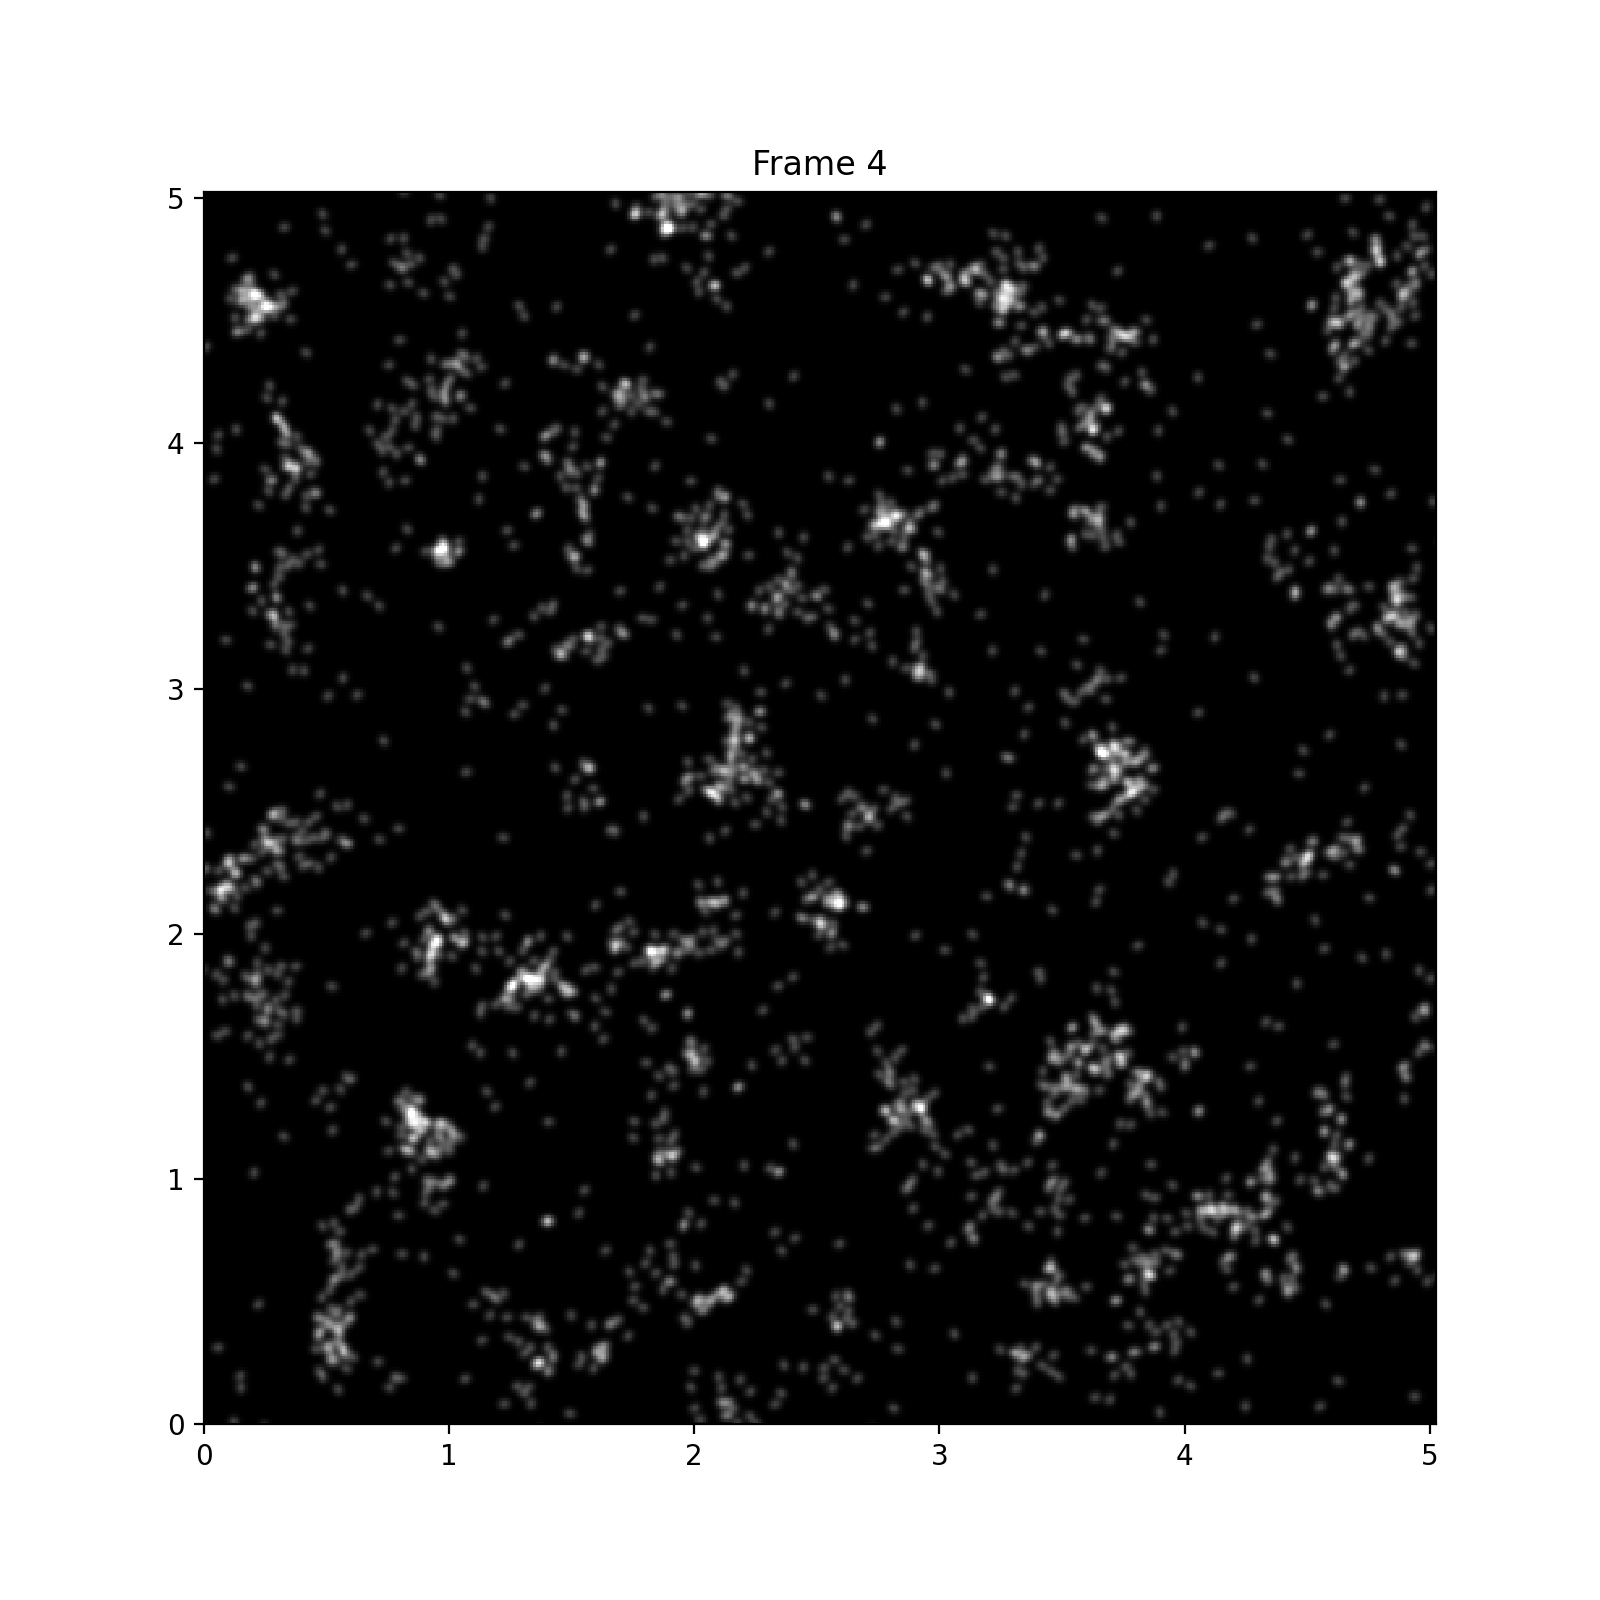

In [28]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
ani = FuncAnimation(fig, animate, len(cap_frames), fargs=(ax, X, Y, cap_frames, 5*image_params['A']), blit=True)

In [32]:
from matplotlib.animation import FFMpegWriter
writer=FFMpegWriter(fps=3, bitrate=1800)
ani.save("test_video.mp4", writer=writer)

# Old

In [10]:
#print "generating microtubule data"
height = 512
pixelSize = imageParams['pixelsize']
noiseStd = imageParams['noisestd']
bkglevel = imageParams['bkglevel']
A = imageParams['A']
sigma = imageParams['sigmaxy']
#offset_distance = imageParams['modeloffset']

numPixelsX = np.int_(np.ceil((height)/pixelSize))
numPixelsY = np.int_(np.ceil((height)/pixelSize))
xpixels = np.arange(0,numPixelsX)
ypixels = np.arange(0,numPixelsY)
[x,y] = np.meshgrid(xpixels, ypixels)

imagedata = bkglevel * np.ones((numPixelsX, numPixelsY)) + np.random.standard_normal((numPixelsX, numPixelsY))*noiseStd

fig, ax = plt.subplots()
ax.set_aspect('equal')
#print "imagedata: {}".format(imagedata)
r0 = np.asarray([25,25])
mlen = 100.
u = np.asarray([2.,1.])
u /= np.linalg.norm(u)
theta = - np.arctan2(u[1], u[0])

derp = GaussianLine2D(x, y, A, sigma, r0[1], r0[0], mlen, theta)
imagedata += derp

r1 = np.asarray([10,50])
mlen1 = 50.
u1 = np.asarray([.5,3.])
u1 /= np.linalg.norm(u)
theta1 = - np.arctan2(u1[1], u1[0])
derp = GaussianLine2D(x, y, A, sigma, r1[1], r1[0], mlen1, theta1)
imagedata += derp


# Loop over microtubules and create the image
#for microtubule in self.microtubules:
#     r0 = microtubule.r - 0.5 * microtubule.v
#     x0 = r0[1]/pixelSize + numPixelsX/2;
#     y0 = r0[2]/pixelSize + numPixelsY/2

#     theta = -np.arctan2(microtubule.u[2], microtubule.u[1])

#     mlen = np.sqrt(microtubule.v[1]*microtubule.v[1] + microtubule.v[2]*microtubule.v[2])/pixelSize

#     derp = GaussianLine2D(x, y, A, sigma, x0, y0, mlen, theta)
#     imagedata = imagedata + derp

#imagedata = np.fliplr(imagedata)

ax.pcolormesh(x,y, imagedata, cmap='gray', vmax=A*5.)
#ax.imshow(imagedata)
# return imagedata


KeyboardInterrupt: 